# Build a model to achieve more than 99.40% test accuracy
## Targets
* **Number of Parameters**: Less than 8 k
* **Image Augmentation** to increases the diversity of the dataset and the robustness of the model
* Added **Learning rate schedular** faster convergence
* And Finally to get more than **99.40% test accuracy** in approximately 15 epochs

## Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Add Data Transformer, Data Loaders and training and testing data

In [ ]:
#Data Transformations

# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-4.0, 4.0), fill=(1,)), # Added data augmentation
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
# Load Train and Test Data
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Configure Test/Train Dataloaders
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


##Model Defination

In [ ]:
class Model4(nn.Module):
    def __init__(self):
        super(Model4, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.Dropout(0.05)
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(5),
            nn.Dropout(0.05)
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05)
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            #nn.Dropout(0.1)
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.Dropout(0.1)
        )

        self.global_avg_pooling = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.global_avg_pooling(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model4().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              27
              ReLU-2            [-1, 3, 28, 28]               0
       BatchNorm2d-3            [-1, 3, 28, 28]               6
           Dropout-4            [-1, 3, 28, 28]               0
            Conv2d-5            [-1, 5, 28, 28]             135
              ReLU-6            [-1, 5, 28, 28]               0
       BatchNorm2d-7            [-1, 5, 28, 28]              10
           Dropout-8            [-1, 5, 28, 28]               0
         MaxPool2d-9            [-1, 5, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             450
             ReLU-11           [-1, 10, 12, 12]               0
      BatchNorm2d-12           [-1, 10, 12, 12]              20
          Dropout-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

##Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

##Start Training and Testing

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Model4().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    print("Learning Rate:", optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0
Learning Rate: 0.01


Loss=0.05533180758357048 Batch_id=468 Accuracy=95.28: 100%|██████████| 469/469 [00:28<00:00, 16.26it/s]



Test set: Average loss: 0.0792, Accuracy: 9796/10000 (97.96%)

EPOCH: 1
Learning Rate: 0.01


Loss=0.03800760582089424 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:21<00:00, 21.69it/s]



Test set: Average loss: 0.0569, Accuracy: 9848/10000 (98.48%)

EPOCH: 2
Learning Rate: 0.01


Loss=0.034184619784355164 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]



Test set: Average loss: 0.0473, Accuracy: 9869/10000 (98.69%)

EPOCH: 3
Learning Rate: 0.01


Loss=0.04799145460128784 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]



Test set: Average loss: 0.0382, Accuracy: 9885/10000 (98.85%)

EPOCH: 4
Learning Rate: 0.01


Loss=0.06496890634298325 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:22<00:00, 20.48it/s]



Test set: Average loss: 0.0383, Accuracy: 9883/10000 (98.83%)

EPOCH: 5
Learning Rate: 0.01


Loss=0.05705529451370239 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:21<00:00, 21.87it/s]



Test set: Average loss: 0.0278, Accuracy: 9907/10000 (99.07%)

EPOCH: 6
Learning Rate: 0.01


Loss=0.02823263220489025 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:21<00:00, 21.44it/s]



Test set: Average loss: 0.0377, Accuracy: 9888/10000 (98.88%)

EPOCH: 7
Learning Rate: 0.01


Loss=0.03900691866874695 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]



Test set: Average loss: 0.0286, Accuracy: 9904/10000 (99.04%)

EPOCH: 8
Learning Rate: 0.01


Loss=0.011167041957378387 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:21<00:00, 21.35it/s]



Test set: Average loss: 0.0245, Accuracy: 9913/10000 (99.13%)

EPOCH: 9
Learning Rate: 0.01


Loss=0.027655204758048058 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:23<00:00, 19.81it/s]



Test set: Average loss: 0.0267, Accuracy: 9916/10000 (99.16%)

EPOCH: 10
Learning Rate: 0.001


Loss=0.018010670319199562 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]



Test set: Average loss: 0.0174, Accuracy: 9947/10000 (99.47%)

EPOCH: 11
Learning Rate: 0.001


Loss=0.007121240720152855 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:21<00:00, 21.39it/s]



Test set: Average loss: 0.0167, Accuracy: 9948/10000 (99.48%)

EPOCH: 12
Learning Rate: 0.001


Loss=0.04693381115794182 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]



Test set: Average loss: 0.0167, Accuracy: 9951/10000 (99.51%)

EPOCH: 13
Learning Rate: 0.001


Loss=0.05206076800823212 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]



Test set: Average loss: 0.0161, Accuracy: 9952/10000 (99.52%)

EPOCH: 14
Learning Rate: 0.001


Loss=0.0024685985408723354 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]



Test set: Average loss: 0.0173, Accuracy: 9950/10000 (99.50%)



## Plot the graphs

Text(0.5, 1.0, 'Test Accuracy')

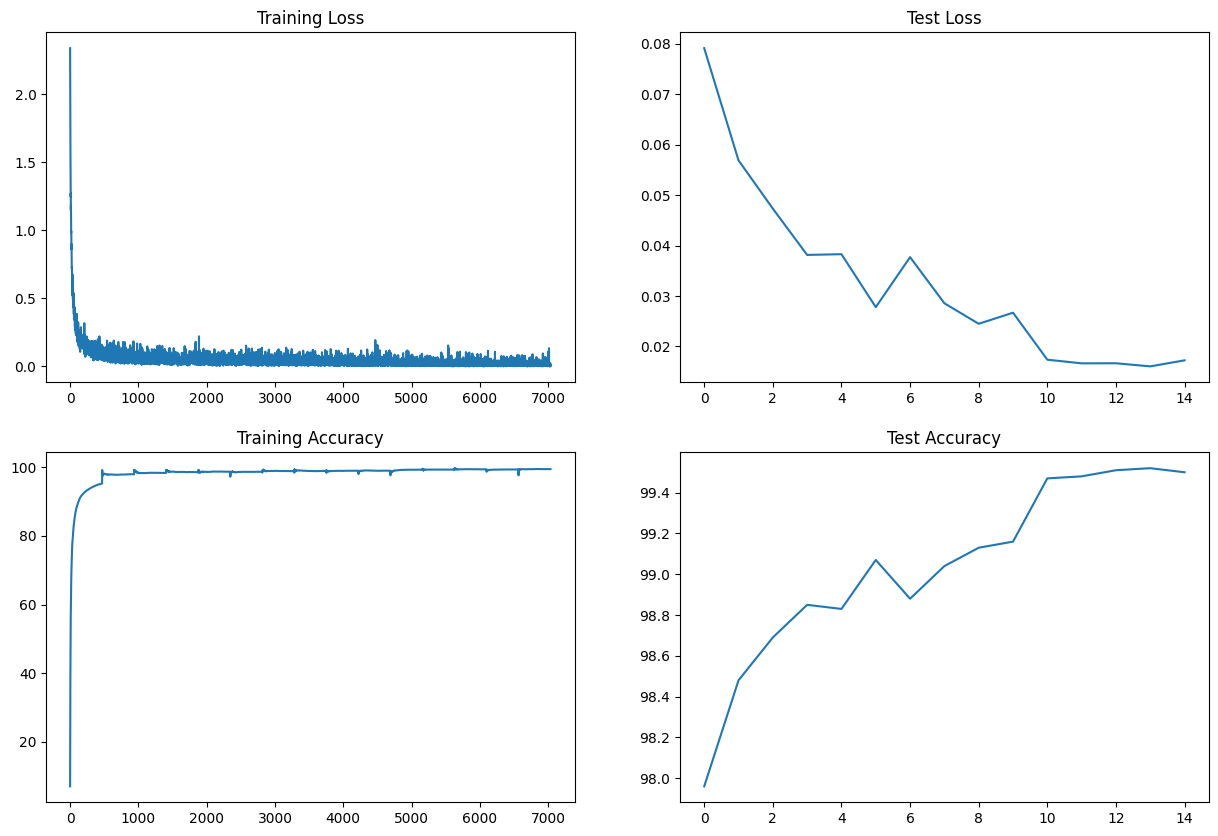

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Result
* **Total number of parameters**: 7.6 k
* **Best Training Accuracy**: 99.47%
* **Best Test Accuracy**: 99.50%

# Analysis
* Both training and testing accuracies are very high (more than 99.47%), which indicates that the **model is capable of learning the patterns** in the data effectively
* Since the test accuracy is very close to the training accuracy, it seems that the model is **not significantly overfitting or underfitting** --> There is no significant gap between training and test accuracy, which is a positive sign
* The close alignment of **training and test accuracy suggests a reasonable fit**